<a href="https://colab.research.google.com/github/cs-iuu/word-sense-2025-fall-ai/blob/main/notebooks/09.word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec
A sample code to turn text into word embeddings.
(Adapted from https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE)

* **NB:** Load les_miserables.txt before running the notebook

## Setup & import libraries

In [1]:
!pip install gensim nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.8 MB/s eta 0:00:00


In [2]:
#future is the missing compatibility layer between Python 2 and Python 3.
#It allows you to use a single, clean Python 3.x-compatible codebase to
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#encoding. word encodig
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re

In [3]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [4]:
#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt
#http://www.nltk.org/
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load the data

In [14]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("*.txt"))

In [15]:
print(book_filenames)

['les_miserables.txt']


In [16]:
#step 1 process data

#initialize rawunicode , we'll add all text to this one bigass file in memory
corpus_raw = u""
#for each book, read it, open it un utf 8 format,
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'les_miserables.txt'...
Corpus is now 3251299 characters long



In [8]:
#tokenizastion! saved the trained model here
# tokenizer = nltk.data.load('../root/nltk_data/tokenizers/punkt/english.pickle')

## Tokenize

In [17]:
#tokenize into sentences
# raw_sentences = tokenizer.tokenize(corpus_raw)
raw_sentences = nltk.sent_tokenize(corpus_raw)

In [18]:
#convert into list of words
#remove unecessary characters, split into words, no hyphens, etc.
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return [word.lower() for word in words]

In [19]:
#for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

### Preprocessing: Remove stop words and lowercase

In [20]:
from nltk.corpus import stopwords

# Download the stopwords dataset if you haven't already
nltk.download('stopwords') # This line is already in cell Jhb77e8Nc8L7

# Get the English stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from each sentence
sentences_no_stopwords = []
for sentence in sentences:
    new_sentence = [word for word in sentence if word.lower() not in stop_words]
    if len(new_sentence) > 0:
        sentences_no_stopwords.append(new_sentence)

# Replace the original sentences list with the one without stop words
sentences = sentences_no_stopwords

print("Number of sentences after removing stop words:", len(sentences))
print("First sentence after removing stop words:", sentences[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of sentences after removing stop words: 29406
First sentence after removing stop words: ['project', 'gutenberg', 'ebook', 'les', 'mis', 'rables', 'victor', 'hugo', 'ebook', 'use', 'anyone', 'anywhere', 'cost', 'almost', 'restrictions', 'whatsoever']


In [21]:
#print an example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

MADELEINE IN MOURNING

 CHAPTER V—VAGUE FLASHES ON THE HORIZON

 CHAPTER VI—FATHER FAUCHELEVENT

 CHAPTER VII—FAUCHELEVENT BECOMES A GARDENER IN PARIS

 CHAPTER VIII—MADAME VICTURNIEN EXPENDS THIRTY FRANCS ON MORALITY

 CHAPTER IX—MADAME VICTURNIEN’S SUCCESS

 CHAPTER X—RESULT OF THE SUCCESS

 CHAPTER XI—CHRISTUS NOS LIBERAVIT

 CHAPTER XII—M.
['madeleine', 'in', 'mourning', 'chapter', 'v', 'vague', 'flashes', 'on', 'the', 'horizon', 'chapter', 'vi', 'father', 'fauchelevent', 'chapter', 'vii', 'fauchelevent', 'becomes', 'a', 'gardener', 'in', 'paris', 'chapter', 'viii', 'madame', 'victurnien', 'expends', 'thirty', 'francs', 'on', 'morality', 'chapter', 'ix', 'madame', 'victurnien', 's', 'success', 'chapter', 'x', 'result', 'of', 'the', 'success', 'chapter', 'xi', 'christus', 'nos', 'liberavit', 'chapter', 'xii', 'm']


In [22]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 279,111 tokens


## Word2Vec

In [23]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [24]:
text2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    vector_size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [25]:
text2vec.build_vocab(sentences)

In [26]:
print("Word2Vec vocabulary length:", len(text2vec.wv.index_to_key))

Word2Vec vocabulary length: 10667


## Train

In [27]:
#train model on sentneces
text2vec.train(sentences, epochs=10, total_examples=len(sentences))

(2566424, 2791110)

In [28]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [29]:
text2vec.save(os.path.join("trained", "text2vec.w2v"))

In [30]:
text2vec = w2v.Word2Vec.load(os.path.join("trained", "text2vec.w2v"))

## Visualize

In [31]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [32]:
#put it all into a giant matrix
all_word_vectors_matrix = text2vec.wv.vectors

In [33]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [34]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[text2vec.wv.key_to_index[word]])
            for word in text2vec.wv.key_to_index
        ]
    ],
    columns=["word", "x", "y"]
)

In [35]:
points.head(10)

,word,x,y
0,one,62.227875,21.475559
1,man,49.912697,37.058502
2,said,9.266005,-40.225395
3,marius,-4.606462,34.609894
4,jean,6.076002,26.692719
5,two,-20.335424,-26.221252
6,valjean,6.075844,26.694643
7,would,20.559759,-32.107449
8,cosette,-3.158600,35.039593
9,like,5.386857,42.538158


In [36]:
#plot
sns.set_context("poster")

<Axes: xlabel='x', ylabel='y'>

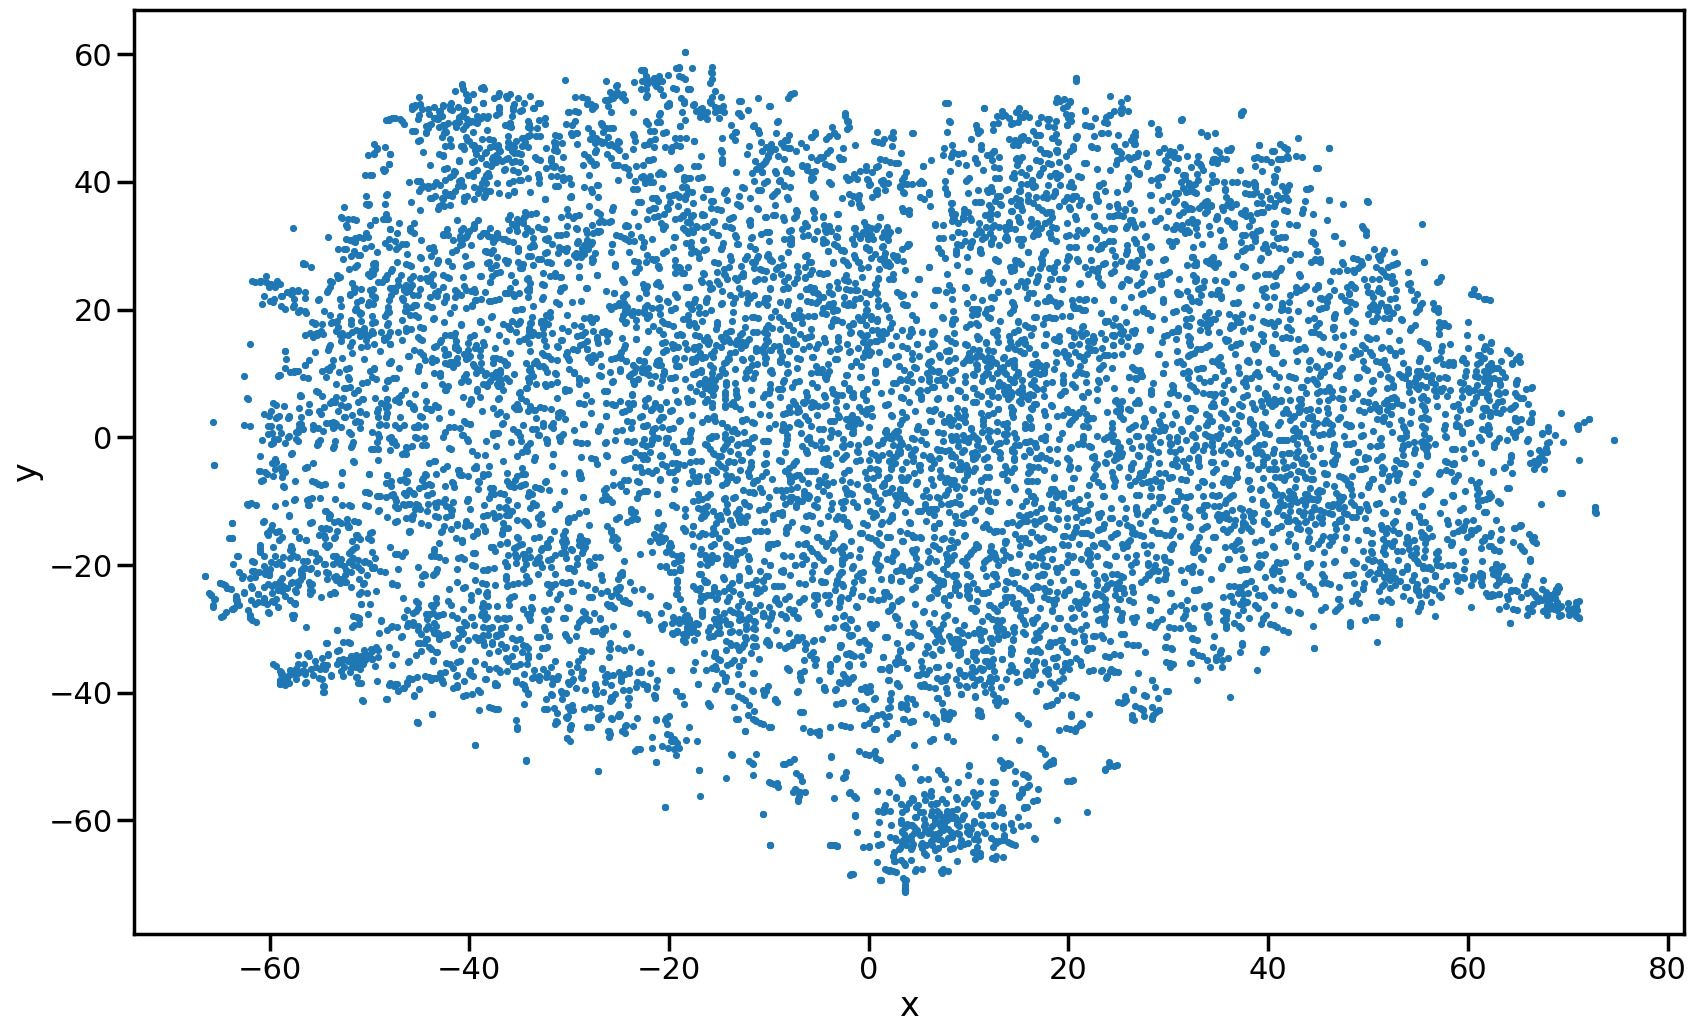

In [37]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [38]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]

    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

## Test & Play

In [39]:
#distance, similarity, and ranking
def analogy(start1, end1, end2):
    # Convert input words to lowercase to match the vocabulary
    start1_lower = start1.lower()
    end1_lower = end1.lower()
    end2_lower = end2.lower()

    similarities = text2vec.wv.most_similar(
        positive=[end2_lower, start1_lower],
        negative=[end1_lower]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {end2} is related to {start2}".format(**locals()))
    return start2

In [40]:
analogy('good', 'fantastic', 'bad')

analogy('Jean', 'Valjean', 'Javert')

good is related to fantastic, as bad is related to receive
Jean is related to Valjean, as Javert is related to inspector


'inspector'

In [41]:
text2vec.wv.most_similar("bishop")

[('monseigneur', 0.6567509174346924),
 ('director', 0.5717037916183472),
 ('beadle', 0.5588013529777527),
 ('luck', 0.5496975183486938),
 ('hospital', 0.5484683513641357),
 ('brutalized', 0.5461968779563904),
 ('madame', 0.544693112373352),
 ('honors', 0.5405637621879578),
 ('magloire', 0.5399345755577087),
 ('ambitious', 0.5394231081008911)]